In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from torchvision import datasets, transforms
import torch

In [3]:
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)

In [4]:
print("Loading EMNIST dataset...")
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.EMNIST(root='./data', split='byclass', train=True, download=True, transform=transform)
test_dataset = datasets.EMNIST(root='./data', split='byclass', train=False, download=True, transform=transform)


Loading EMNIST dataset...


In [5]:
print(f"Training Samples: {len(train_dataset)}")
print(f"Testing Samples: {len(test_dataset)}")
print(f"Number of Classes: {len(train_dataset.classes)}")

Training Samples: 697932
Testing Samples: 116323
Number of Classes: 62


In [6]:
train_indices = np.random.choice(len(train_dataset), 120000, replace=False)
small_train_dataset = torch.utils.data.Subset(train_dataset, train_indices)

test_indices = np.random.choice(len(test_dataset), 20000, replace=False)
small_test_dataset = torch.utils.data.Subset(test_dataset, test_indices)


In [7]:
x_train = small_train_dataset.dataset.data[small_train_dataset.indices].numpy().reshape(-1, 28, 28, 1)
y_train = small_train_dataset.dataset.targets[small_train_dataset.indices].numpy()

x_test = small_test_dataset.dataset.data[small_test_dataset.indices].numpy().reshape(-1, 28, 28, 1)
y_test = small_test_dataset.dataset.targets[small_test_dataset.indices].numpy()

In [8]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")


x_train shape: (120000, 28, 28, 1)
y_train shape: (120000,)
x_test shape: (20000, 28, 28, 1)
y_test shape: (20000,)


In [9]:
class_counts = np.bincount(y_train)
plt.figure(figsize=(15, 5))
plt.bar(range(len(class_counts)), class_counts)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.savefig('class_distribution.png')
plt.close()

In [10]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title(f'Class: {y_train[i]}')
    plt.axis('off')
plt.tight_layout()
plt.savefig('sample_images.png')
plt.close()

In [11]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.15, random_state=42, stratify=y_train
)


In [12]:
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


In [13]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# One-hot encode the labels
y_train_onehot = to_categorical(y_train, num_classes=62)
y_val_onehot = to_categorical(y_val, num_classes=62)
y_test_onehot = to_categorical(y_test, num_classes=62)


In [14]:
datagen = ImageDataGenerator(
    rotation_range=10,  # Reduced from 30 to 10 degrees
    width_shift_range=0.1,  # Reduced from 0.2 to 0.1
    height_shift_range=0.1,  # Reduced from 0.2 to 0.1
    zoom_range=0.1,  # Reduced from 0.2 to 0.1
    fill_mode='nearest',
    horizontal_flip=False,
    vertical_flip=False
)


In [15]:
datagen.fit(x_train)

In [26]:
def create_improved_model():
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(0.001),
                      input_shape=(28, 28, 1)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Flatten and Dense layers
        layers.Flatten(),
        layers.Dense(256, activation='relu',
                    kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(62, activation='softmax')
    ])

    return model

In [27]:
model = create_improved_model()


In [28]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [29]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 62)             │        15,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 498,942 (1.90 MB)

 Trainable params: 497,662 (1.90 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [30]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

In [31]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

In [32]:
model_checkpoint = ModelCheckpoint(
    'best_emnist_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [33]:
history = model.fit(
    datagen.flow(x_train, y_train_onehot, batch_size=64),
    epochs=20,
    validation_data=(x_val, y_val_onehot),
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.3706 - loss: 3.2374
Epoch 1: val_accuracy improved from -inf to 0.77294, saving model to best_emnist_model.h5


1594/1594 ━━━━━━━━━━━━━━━━━━━━ 493s 306ms/step - accuracy: 0.3706 - loss: 3.2369 - val_accuracy: 0.7729 - val_loss: 1.2553 - learning_rate: 0.0010
Epoch 2/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.6622 - loss: 1.5763
Epoch 2: val_accuracy did not improve from 0.77294
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 593s 372ms/step - accuracy: 0.6622 - loss: 1.5763 - val_accuracy: 0.7302 - val_loss: 1.1164 - learning_rate: 0.0010
Epoch 3/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.6803 - loss: 1.3794
Epoch 3: val_accuracy improved from 0.77294 to 0.79383, saving model to best_emnist_model.h5


1594/1594 ━━━━━━━━━━━━━━━━━━━━ 577s 362ms/step - accuracy: 0.6803 - loss: 1.3794 - val_accuracy: 0.7938 - val_loss: 0.9920 - learning_rate: 0.0010
Epoch 4/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.6844 - loss: 1.3215
Epoch 4: val_accuracy did not improve from 0.79383
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 550s 345ms/step - accuracy: 0.6844 - loss: 1.3215 - val_accuracy: 0.7406 - val_loss: 1.1099 - learning_rate: 0.0010
Epoch 5/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7004 - loss: 1.2872
Epoch 5: val_accuracy did not improve from 0.79383
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 2118s 1s/step - accuracy: 0.7004 - loss: 1.2872 - val_accuracy: 0.7782 - val_loss: 0.9970 - learning_rate: 0.0010
Epoch 6/20
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.7000 - loss: 1.2739
Epoch 6: val_accuracy did not improve from 0.79383
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 798s 501ms/step - accuracy: 0.7000 - loss: 1.2739 - val_accuracy: 0.7354 - val_loss: 1.0728 - learning_rate: 0

In [34]:
model = keras.models.load_model('best_emnist_model.h5')

In [35]:
test_loss, test_acc = model.evaluate(x_test, y_test_onehot, verbose=1)
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')

625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.7983 - loss: 0.9836
Test accuracy: 0.7975
Test loss: 0.9881


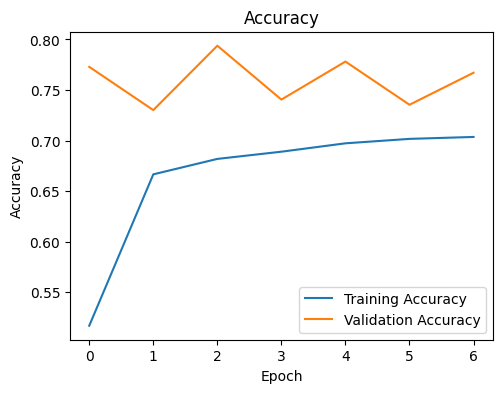

In [36]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [37]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('training_history.png')
plt.close()

In [38]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_onehot, axis=1)

625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step


In [39]:
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes))


Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.84      0.72       951
           1       0.67      0.79      0.73      1090
           2       0.96      0.82      0.89      1004
           3       0.99      0.99      0.99      1070
           4       0.98      0.85      0.91       997
           5       0.92      0.90      0.91       883
           6       0.99      0.84      0.91       975
           7       0.99      0.96      0.97      1047
           8       0.98      0.90      0.94       958
           9       0.95      0.88      0.91       963
          10       0.97      0.93      0.95       199
          11       0.70      0.95      0.81       109
          12       0.84      0.50      0.63       312
          13       0.84      0.83      0.84       143
          14       0.98      0.94      0.96       154
          15       0.77      0.92      0.84       242
          16       0.71      0.97      0.82        75
   

In [40]:
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true_classes, y_pred_classes)

<Figure size 1200x1000 with 0 Axes>

In [41]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [42]:
sns.heatmap(cm_norm[:10, :10], annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (First 10 Classes)')
plt.savefig('confusion_matrix.png')
plt.close()

In [43]:
misclassified_indices = np.where(y_pred_classes != y_true_classes)[0]
num_to_display = min(25, len(misclassified_indices))
selected_indices = np.random.choice(misclassified_indices, num_to_display, replace=False)


In [44]:
plt.figure(figsize=(12, 12))
for i, idx in enumerate(selected_indices):
    plt.subplot(5, 5, i+1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f'True: {y_true_classes[idx]}\nPred: {y_pred_classes[idx]}')
    plt.axis('off')
plt.tight_layout()
plt.savefig('misclassified_examples.png')
plt.close()

In [45]:
model.save('improved_emnist_model.h5')  # HDF5 format
#model.save('improved_emnist_model')

In [46]:
def predict_character(image_array, model):
    """
    Perform prediction on a single character image

    Args:
        image_array: Numpy array of shape (28, 28) or (28, 28, 1)
        model: Loaded Keras model

    Returns:
        Predicted class and confidence
    """
    # Ensure correct shape (28, 28, 1)
    if len(image_array.shape) == 2:
        image_array = image_array.reshape(1, 28, 28, 1)
    elif len(image_array.shape) == 3 and image_array.shape[0] == 1:
        image_array = image_array.reshape(1, 28, 28, 1)

    # Normalize
    image_array = image_array.astype('float32') / 255.0

    # Predict
    predictions = model.predict(image_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    confidence = np.max(predictions)

    return predicted_class, confidence

print("Model training and evaluation complete!")

Model training and evaluation complete!


Testing on random samples from the EMNIST test dataset...


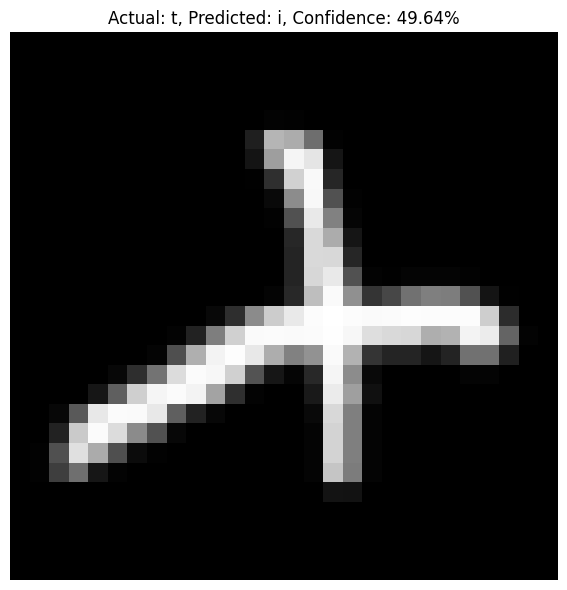

Sample 42912:
  Actual: t
  Predicted: i
  Confidence: 49.64%
------------------------------


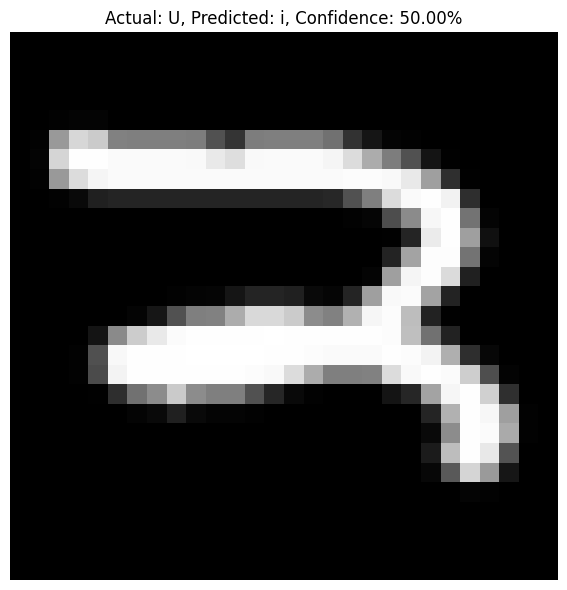

Sample 25417:
  Actual: U
  Predicted: i
  Confidence: 50.00%
------------------------------


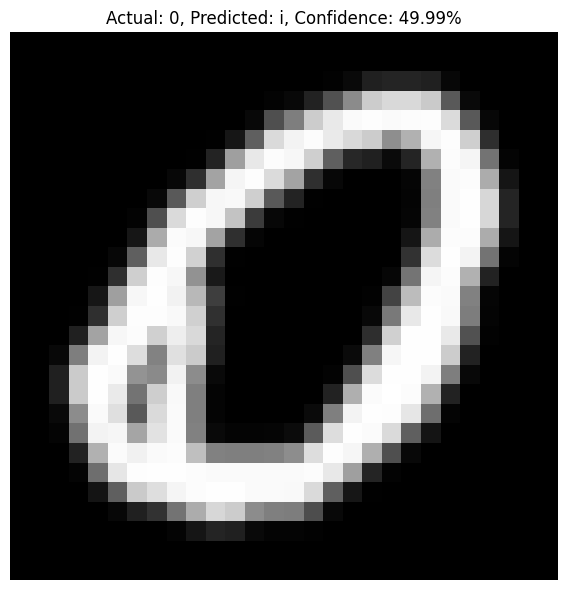

Sample 74346:
  Actual: 0
  Predicted: i
  Confidence: 49.99%
------------------------------


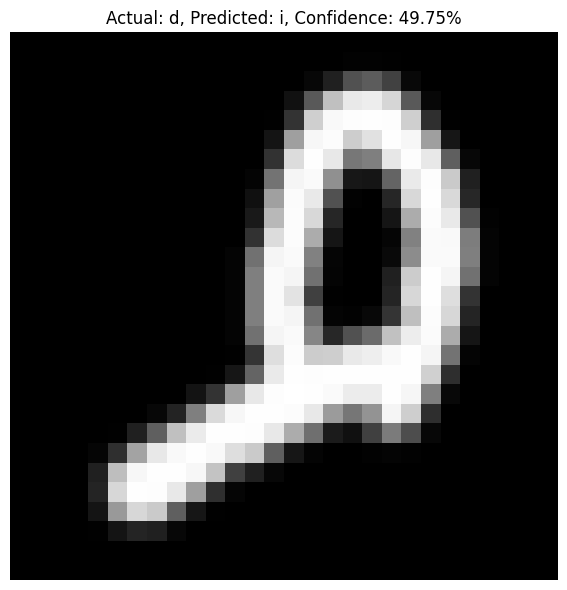

Sample 20933:
  Actual: d
  Predicted: i
  Confidence: 49.75%
------------------------------
To test your model on your own images, run the custom_image_test.py script.


In [48]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import random
from torchvision import datasets, transforms
import torch

# Load the saved model
model_path = 'improved_emnist_model.h5'  # or 'best_emnist_model.h5'
model = keras.models.load_model(model_path)

# Class mapping for EMNIST byclass (maps class indices to actual characters)
def get_class_mapping():
    # EMNIST 'byclass' mapping according to the dataset documentation
    # 0-9: Digits
    # 10-35: Uppercase letters
    # 36-61: Lowercase letters
    mapping = {}

    # Digits (0-9)
    for i in range(10):
        mapping[i] = str(i)

    # Uppercase letters (A-Z)
    for i in range(26):
        mapping[i + 10] = chr(65 + i)  # ASCII: A=65, B=66, etc.

    # Lowercase letters (a-z)
    for i in range(26):
        mapping[i + 36] = chr(97 + i)  # ASCII: a=97, b=98, etc.

    return mapping

# Function to preprocess a numpy array
def preprocess_array(img_array):
    """
    Preprocess a numpy array to be compatible with the EMNIST model
    """
    # Normalize to [0, 1]
    img_array = img_array.astype('float32') / 255.0

    # Reshape to expected format (1, 28, 28, 1)
    img_array = img_array.reshape(1, 28, 28, 1)

    return img_array

# Function to make a prediction
def predict_character(image_array, model, class_mapping=None):
    """
    Predict the character from an image array

    Args:
        image_array: Numpy array of the image
        model: The loaded Keras model
        class_mapping: Dictionary mapping class indices to characters

    Returns:
        Predicted character, class index, and confidence
    """
    # Preprocess the image
    processed_image = preprocess_array(image_array)

    # Make prediction
    predictions = model.predict(processed_image, verbose=0)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0]) * 100  # Convert to percentage

    # Get character from class mapping if provided
    if class_mapping is not None:
        predicted_char = class_mapping.get(predicted_class, f"Unknown ({predicted_class})")
    else:
        predicted_char = str(predicted_class)

    return predicted_char, predicted_class, confidence

# Function to visualize the prediction
def visualize_prediction(image_array, predicted_char, confidence, original_class=None):
    """
    Visualize the image and prediction
    """
    # Create the plot
    plt.figure(figsize=(6, 6))
    plt.imshow(image_array, cmap='gray')

    title = f"Predicted: {predicted_char}, Confidence: {confidence:.2f}%"
    if original_class is not None:
        title = f"Actual: {original_class}, " + title

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Test on random samples from the test dataset
def test_on_random_samples(num_samples=5):
    """
    Test the model on random samples from the EMNIST test dataset
    """
    print("Testing on random samples from the EMNIST test dataset...")

    # Load EMNIST test dataset
    transform = transforms.Compose([transforms.ToTensor()])
    test_dataset = datasets.EMNIST(root='./data', split='byclass', train=False, download=True, transform=transform)

    # Get class mapping
    class_mapping = get_class_mapping()

    # Select random samples
    sample_indices = random.sample(range(len(test_dataset)), num_samples)

    for idx in sample_indices:
        # Get image and label
        image, label = test_dataset[idx]
        image_np = image.numpy().reshape(28, 28)

        # Handle label - convert tensor to int if needed
        if isinstance(label, torch.Tensor):
            label_value = label.item()
        else:
            label_value = label

        # Predict
        pred_char, pred_class, confidence = predict_character(image_np, model, class_mapping)

        # Visualize
        visualize_prediction(image_np, pred_char, confidence, class_mapping.get(label_value))

        print(f"Sample {idx}:")
        print(f"  Actual: {class_mapping.get(label_value)}")
        print(f"  Predicted: {pred_char}")
        print(f"  Confidence: {confidence:.2f}%")
        print("-" * 30)

# Main execution
if __name__ == "__main__":
    # Test on random samples from the test dataset
    test_on_random_samples(4)

    print("To test your model on your own images, run the custom_image_test.py script.")

EMNIST Character Recognition - Colab Test
--------------------------------------------------
1. Upload and test an image
2. Capture image from webcam (if available)
Please upload an image...


Saving images (1).png to images (1) (1).png
Testing image: images (1) (1).png


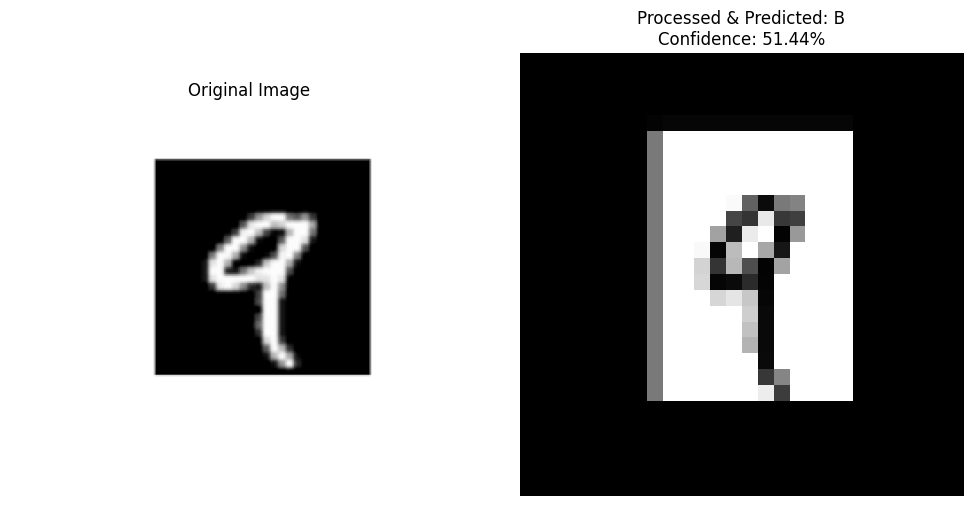

Predicted: B
Confidence: 51.44%
------------------------------


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from PIL import Image
import cv2
from google.colab import files
import os

# Load the saved model
# Make sure to upload your model to Colab first
model_path = 'improved_emnist_model.h5'  # or 'best_emnist_model.h5'
model = keras.models.load_model(model_path)

# Class mapping for EMNIST byclass (maps class indices to actual characters)
def get_class_mapping():
    # EMNIST 'byclass' mapping according to the dataset documentation
    # 0-9: Digits
    # 10-35: Uppercase letters
    # 36-61: Lowercase letters
    mapping = {}

    # Digits (0-9)
    for i in range(10):
        mapping[i] = str(i)

    # Uppercase letters (A-Z)
    for i in range(26):
        mapping[i + 10] = chr(65 + i)  # ASCII: A=65, B=66, etc.

    # Lowercase letters (a-z)
    for i in range(26):
        mapping[i + 36] = chr(97 + i)  # ASCII: a=97, b=98, etc.

    return mapping

# Function to preprocess an image file
def preprocess_image(img):
    """
    Preprocess image to be compatible with the EMNIST model
    """
    # Convert to grayscale if needed
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Resize to 28x28
    img = cv2.resize(img, (28, 28))

    # Convert to numpy array if not already
    img_array = np.array(img)

    # Invert if needed (EMNIST expects white digit on black background)
    # Check if the image is already inverted by comparing average pixel value
    if np.mean(img_array) > 127:
        img_array = 255 - img_array  # Invert

    # Normalize to [0, 1]
    img_array = img_array.astype('float32') / 255.0

    # Reshape to expected format (1, 28, 28, 1)
    img_array = img_array.reshape(1, 28, 28, 1)

    return img_array, img

# Function to make a prediction
def predict_character(img, model):
    """
    Predict the character from an image

    Args:
        img: Image array
        model: The loaded Keras model

    Returns:
        Predicted character, class index, confidence, and processed image
    """
    # Get class mapping
    class_mapping = get_class_mapping()

    # Preprocess the image
    processed_image, original_img = preprocess_image(img)

    # Make prediction
    predictions = model.predict(processed_image, verbose=0)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0]) * 100  # Convert to percentage

    # Get character from class mapping
    predicted_char = class_mapping.get(predicted_class, f"Unknown ({predicted_class})")

    return predicted_char, predicted_class, confidence, processed_image[0,:,:,0]

# Function to upload and test an image
def upload_and_test_image():
    """
    Upload an image through Colab and test the model on it
    """
    print("Please upload an image...")
    uploaded = files.upload()

    for filename in uploaded.keys():
        # Read the image
        img = cv2.imread(filename)
        if img is None:
            print(f"Error: Could not read image {filename}")
            continue

        # Convert BGR to RGB (cv2 reads as BGR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        print(f"Testing image: {filename}")

        # Predict
        pred_char, pred_class, confidence, processed_img = predict_character(img, model)

        # Display the original and processed image
        plt.figure(figsize=(10, 5))

        # Original image
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis('off')

        # Processed and predicted
        plt.subplot(1, 2, 2)
        plt.imshow(processed_img, cmap='gray')
        plt.title(f"Processed & Predicted: {pred_char}\nConfidence: {confidence:.2f}%")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"Predicted: {pred_char}")
        print(f"Confidence: {confidence:.2f}%")
        print("-" * 30)

# Function to take a photo using the webcam (if available in Colab)
def webcam_capture_and_test():
    """
    Capture an image from webcam and test the model on it
    """
    from IPython.display import display, Javascript
    from google.colab.output import eval_js
    from base64 import b64decode

    def take_photo(filename='photo.jpg', quality=0.8):
        js = Javascript('''
            async function takePhoto(quality) {
                const div = document.createElement('div');
                const capture = document.createElement('button');
                capture.textContent = 'Capture';
                div.appendChild(capture);

                const video = document.createElement('video');
                video.style.display = 'block';
                const stream = await navigator.mediaDevices.getUserMedia({video: true});
                document.body.appendChild(div);
                div.appendChild(video);
                video.srcObject = stream;
                await video.play();

                // Resize the output to fit the video element.
                google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

                // Wait for Capture to be clicked.
                await new Promise((resolve) => {
                    capture.onclick = resolve;
                });

                const canvas = document.createElement('canvas');
                canvas.width = video.videoWidth;
                canvas.height = video.videoHeight;
                canvas.getContext('2d').drawImage(video, 0, 0);
                stream.getVideoTracks()[0].stop();
                div.remove();
                return canvas.toDataURL('image/jpeg', quality);
            }
            ''')
        display(js)
        data = eval_js('takePhoto({})'.format(quality))
        binary = b64decode(data.split(',')[1])
        with open(filename, 'wb') as f:
            f.write(binary)
        return filename

    # Take photo using webcam
    try:
        filename = take_photo('captured_image.jpg')
        print(f'Saved to {filename}')

        # Read the captured image
        img = cv2.imread(filename)
        if img is None:
            print(f"Error: Could not read captured image")
            return

        # Convert BGR to RGB (cv2 reads as BGR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Predict
        pred_char, pred_class, confidence, processed_img = predict_character(img, model)

        # Display the original and processed image
        plt.figure(figsize=(10, 5))

        # Original image
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title("Captured Image")
        plt.axis('off')

        # Processed and predicted
        plt.subplot(1, 2, 2)
        plt.imshow(processed_img, cmap='gray')
        plt.title(f"Processed & Predicted: {pred_char}\nConfidence: {confidence:.2f}%")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"Predicted: {pred_char}")
        print(f"Confidence: {confidence:.2f}%")

    except Exception as e:
        print(f"Error capturing image: {str(e)}")
        print("Webcam capture may not be supported in your Colab environment.")
        print("Try using the upload option instead.")

# Main execution - Colab friendly menu
print("EMNIST Character Recognition - Colab Test")
print("-" * 50)
print("1. Upload and test an image")
print("2. Capture image from webcam (if available)")

try:
    # Use Colab's input instead of regular input
    from google.colab import output
    mode = output.eval_js('prompt("Select mode (1 or 2):")')

    if mode == "1":
        upload_and_test_image()
    elif mode == "2":
        webcam_capture_and_test()
    else:
        print("Invalid selection. Please run the cell again and select 1 or 2.")
except:
    # Fallback to regular input if not in Colab
    mode = input("Select mode (1 or 2): ")

    if mode == "1":
        upload_and_test_image()
    elif mode == "2":
        print("Webcam capture is only available in Colab environment.")
    else:
        print("Invalid selection. Please run the cell again and select 1 or 2.")